## WS25: Seminar: Business Analytics (Master) - BWL 12
### Topic: Supply Chain Resilience under Disruptions — An Agent-Based Simulation with Mesa

### 1. Introduction

Global supply chains are complex, interconnected systems that face **random disruptions**, such as:
- Supplier failures or capacity loss  
- Transportation delays and bottlenecks  
- Demand spikes or market shocks  

These disruptions propagate across multiple tiers (suppliers → plants → distribution centers → retailers), 
creating **ripple effects** that impact service levels, costs, and operational stability.

This simulation implements a **multi-tier supply chain network** using an **Agent-Based Model (ABM)** 
built with the open-source framework **Mesa**.  
The goal is to study how different **resilience strategies** (e.g., dual sourcing, safety stocks, flexible capacity, 
and dynamic reallocation) influence overall network performance under stochastic disruptions.

In [1]:
from model import MultiTierModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### 2. Key Assumptions

The model is intentionally simplified to focus on the *core dynamics* of disruption propagation 
and recovery behavior. 

Key assumptions include:

| | Assumption |
|-----------|-------------|
| Network Structure | Four tiers: Suppliers → Plants → Distribution Centers (DCs) → Retailers |
| Demand | Retailer demand follows a Poisson distribution with mean λ = 5 |
| Production | Suppliers and plants produce up to their capacity limits each period |
| Inventory | All firms follow a **base-stock policy** to determine order quantity |
| Lead Time | Orders are fulfilled after a one-period delay |
| Disruption | Random capacity loss or delay can occur at supplier or plant level |
| Recovery | Capacity gradually returns to normal after disruption ends |
| Information | Each agent only knows its local inventory and orders (decentralized decisions) |
| Sourcing | Can be single or dual sourcing, depending on scenario configuration |

These assumptions allow for controlled experiments to analyze **systemic resilience** rather than detailed industry realism.

In [2]:
assumptions = {
    "n_suppliers": 3,
    "n_plants": 3,
    "n_dcs": 2,
    "n_retailers": 5,
    "base_stock": {"supplier": 100, "plant": 80, "dc": 60, "retailer": 30},
    "capacity": {"supplier": 20, "plant": 15, "dc": 10, "retailer": 0},
    "lead_time": {"supplier": 1, "plant": 5, "dc": 5, "retailer": 2},
    "capacity_loss_frac": 0.5,
    "recovery_duration": 5
}

n_steps = 50

model = MultiTierModel(
    assumptions=assumptions,
    seed=42,
    dual_sourcing=True,
    disruption_at_step=10
)

### 3. Agents

Each firm in the network is represented as an **agent** (class `BaseFirm`) in Mesa.

#### Agent Structure

| Attribute | Description |
|------------|-------------|
| `tier` | Position in the supply chain (`supplier`, `plant`, `dc`, `retailer`) |
| `inventory` | On-hand inventory level |
| `capacity` | Maximum production or shipment rate per period |
| `base_stock` | Target inventory level under the base-stock policy |
| `on_order` | Goods ordered but not yet received |
| `backlog` | Unmet demand carried over to future periods |
| `fulfilled_demand` | Cumulative demand satisfied |
| `total_demand` | Total customer demand received |
| `order_history` | Time series of orders (used for bullwhip effect calculation) |

#### Agent Behavior (per simulation step)

1. **Retailers generate customer demand** (Poisson process).  
2. **Firms fulfill demand** using available inventory; unmet demand becomes **backlog**.  
3. **Agents compute new orders** using the base-stock policy:  
   \[
   \text{Order} = \max(0, \text{Base Stock} - (\text{Inventory} + \text{On Order} - \text{Backlog}))
   \]
4. **Upstream agents produce goods** subject to capacity constraints.  
5. **Shipments arrive** after a fixed lead time.

Through these simple local rules, complex **network-level phenomena** emerge, such as inventory oscillations and order amplification.


#### 4. Model Structure

The simulation model (`MultiTierModel`) coordinates the interactions among all agents.

##### Model Components

| Component | Description |
|------------|-------------|
| `agents` | List of all agents in the network |
| `links` | Directed supply relationships between tiers |
| `orders` | Queue of pending orders from downstream to upstream |
| `seed` | Random seed for reproducibility |

##### Simulation Flow (per period)

1. **Disruption step:** Randomly reduce capacity or increase lead time for affected agents.  
2. **Ordering step:** Each agent places orders according to its base-stock policy.  
3. **Production step:** Suppliers and plants produce goods up to available capacity.  
4. **Receiving step:** Shipments from previous steps arrive downstream.  
5. **Performance metrics:** Model computes key performance indicators (KPIs).

In [3]:
fill_rates = []
bullwhips = []
total_costs = []

for step in range(n_steps):
    model.step()
    fill_rates.append(model.compute_fill_rate())
    bullwhips.append(model.compute_bullwhip())
    total_costs.append(model.compute_total_cost())

Disruption at step 10 | Victim: <Firm 5 | Tier: plant | Inv: 174 | Backlog: 0 | On order: 0>


#### 5. Key Performance Indicators (KPIs)

The model tracks several KPIs to evaluate resilience and efficiency:

| KPI | Formula / Definition | Interpretation |
|------|----------------------|----------------|
| **Fill Rate** | (Total fulfilled demand) / (Total demand) | Measures customer service level |
| **Total Cost** | Sum of inventory holding + backlog + production costs | Captures operational efficiency |
| **Bullwhip Ratio** | Variance of orders / Variance of demand | Measures demand amplification upstream |
| **Time to Recover (TTR)** | Periods until service level returns to pre-disruption level | Quantifies resilience speed |

/tmp/ipykernel_35798/1658914141.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = results.replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


,step,fill_rate,bullwhip,total_cost
9,10,0.908000,0.281911,11882
10,11,0.856115,0.306244,13782
11,12,0.842623,0.292785,15803
12,13,0.834862,0.301502,17948
13,14,0.838150,0.401201,20187
14,15,0.837333,0.396091,22513
15,16,0.835859,0.395151,24938
16,17,0.842995,0.521625,27463
17,18,0.850575,0.483834,30072
18,19,0.857768,0.475389,32772


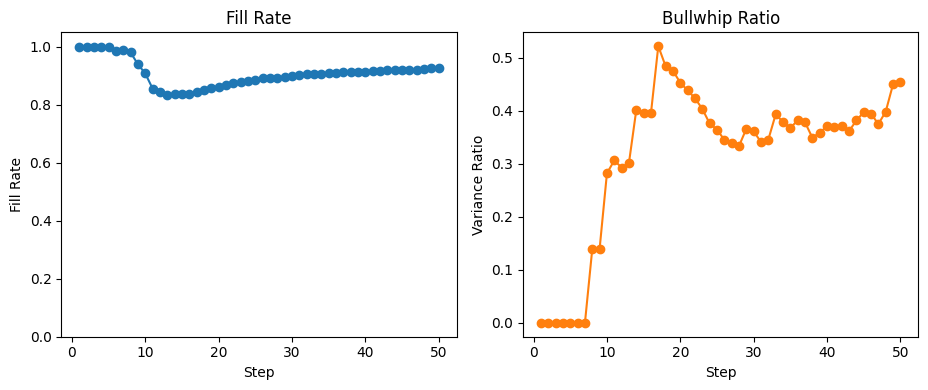

✅ Simulation completed.
Steps simulated: 50
Final Fill Rate: 0.926
Final Total Cost: 158792.00
Final Bullwhip Ratio: 0.455
Time to recover: 25.0


In [5]:
# ---------------------------
# 5. Build result dataframe
# ---------------------------
results = pd.DataFrame({
    "step": range(1, n_steps + 1),
    "fill_rate": fill_rates,
    "bullwhip": bullwhips,
    "total_cost": total_costs
})

# Replace NaN (if any) to make plots look cleaner
results = results.replace([np.inf, -np.inf], np.nan).fillna(method="ffill")

display(results.iloc[9:20])

# ---------------------------
# 6. Plot KPIs
# ---------------------------
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(results["step"], results["fill_rate"], marker='o', color='tab:blue')
plt.title("Fill Rate")
plt.xlabel("Step")
plt.ylabel("Fill Rate")
plt.ylim(0, 1.05)

plt.subplot(1, 3, 2)
plt.plot(results["step"], results["bullwhip"], marker='o', color='tab:orange')
plt.title("Bullwhip Ratio")
plt.xlabel("Step")
plt.ylabel("Variance Ratio")

plt.tight_layout()
plt.show()

# ---------------------------
# 7. Summary statistics
# ---------------------------
print("✅ Simulation completed.")
print(f"Steps simulated: {n_steps}")
print(f"Final Fill Rate: {results['fill_rate'].iloc[-1]:.3f}")
print(f"Final Total Cost: {results['total_cost'].iloc[-1]:.2f}")
print(f"Final Bullwhip Ratio: {results['bullwhip'].iloc[-1]:.3f}")
print(f"Time to recover: {model.compute_time_to_recover():.1f}")
